# Fast Style Transfer for Arbitrary Styles


Based on the model code in [magenta](https://github.com/tensorflow/magenta/tree/master/magenta/models/arbitrary_image_stylization) and the publication:

[Exploring the structure of a real-time, arbitrary neural artistic stylization
network](https://arxiv.org/abs/1705.06830).
*Golnaz Ghiasi, Honglak Lee,
Manjunath Kudlur, Vincent Dumoulin, Jonathon Shlens*,
Proceedings of the British Machine Vision Conference (BMVC), 2017.


## Setup

Let's start with importing TF-2 and all relevant dependencies.

In [1]:
import functools
import os

from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

print("TF Version: ", tf.__version__)
print("TF-Hub version: ", hub.__version__)
print("Eager mode enabled: ", tf.executing_eagerly())

TF Version:  2.3.1
TF-Hub version:  0.10.0
Eager mode enabled:  True


In [4]:
def crop_center(image):
  """Returns a cropped square image."""
  shape = image.shape
  new_shape = min(shape[1], shape[2])
  offset_y = max(shape[1] - shape[2], 0) // 2
  offset_x = max(shape[2] - shape[1], 0) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_y, offset_x, new_shape, new_shape)
  return image

@functools.lru_cache(maxsize=None)
def load_image(image_url, image_size=(256, 256), preserve_aspect_ratio=True):
  """Loads and preprocesses images."""
  # Cache image file locally.
  image_path = tf.keras.utils.get_file(os.path.basename(image_url)[-128:], image_url)
  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img = plt.imread(image_path).astype(np.float32)[np.newaxis, ...]
  if img.max() > 1.0:
    img = img / 255.
  if len(img.shape) == 3:
    img = tf.stack([img, img, img], axis=-1)
  img = crop_center(img)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
  return img

def show_n(images, titles=('',)):
  n = len(images)
  image_sizes = [image.shape[1] for image in images]
  w = (image_sizes[0] * 6) // 320
  plt.figure(figsize=(w  * n, w))
  gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
  for i in range(n):
    plt.subplot(gs[i])
    plt.imshow(images[i][0], aspect='equal')
    plt.axis('off')
    plt.title(titles[i] if len(titles) > i else '')
  plt.show()


Let's get as well some images to play with.

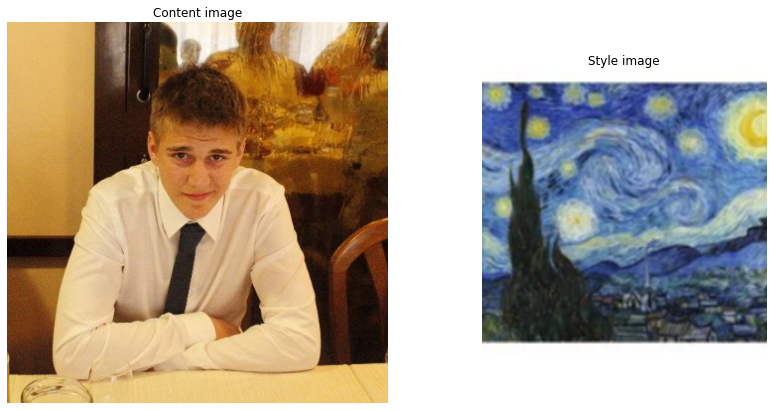

In [5]:
# @title Load example images  { display-mode: "form" }

content_image_url = 'https://pbs.twimg.com/profile_images/461402444509892608/QTXIevg3.jpeg'  # @param {type:"string"}
style_image_url = 'data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxMTEhUTExMWFRUWGBoYFxgXGRofHRofGBodGBcZGhodICggHhsmIB8bIjEhJSkrLi4uGR8zODMsNygtLisBCgoKDg0OGxAQGzUmICUtNS81LSstLS0tNS8yLS0tLS0rLS0vLS0tLS0vLS0tLS0tLS0tLS0tLS0tLS0tLS0tLf/AABEIAMoA+gMBIgACEQEDEQH/xAAcAAACAgMBAQAAAAAAAAAAAAAEBQMGAAIHAQj/xABIEAABAgQDBQUGAwUFBgcBAAABAhEAAyExBBJBBSJRYXEGE4GRoTJCscHR8BQjUmJykuHxFjOistIVNFRzgpMHJFN0g4TCQ//EABoBAAIDAQEAAAAAAAAAAAAAAAIDAAEEBQb/xAAuEQACAgIBAwIFAwQDAAAAAAAAAQIRAyExBBITQVEUImGx8AWBwVJxofEykeH/2gAMAwEAAhEDEQA/AO4xkZHzhtrtBjEbQxIGMxISnEzwlKcQrIlImrAGUkgABgA3lBwg58FN0fR8Y8fNkvtDjJgCU43FXuJ81y5pUMG00i8bNxeJDEz5y91qzpj0YAkZmKnd7weTC4R7pMDyI63GRyzGLxCgUqxOISC/szVJV/0qB0pw1iodqMVjZK0LlYvGAEtlOImlKykJJYZixNQRQcIXiUcquDstzp0z6CjI+YU9q8eS4xOKTUlu9na8lLL9Gi4YHaOKmSwZuKxQKgGUmatNw7sFBm6QyeHsj3SaSJ326SO3RkfOe3dqY2QsBOMxhQwvOm1NKjeBY0LPSoiHZvabGKUofjMU5FQZk0tV3AzFvSGQ6Zz4YPkR9JRkcW2Lj8UsIWrFz1BzQTZg4+1X0MHY7Ez1hQGIxCRRiidNfoGU/jzhMoJT7L/PuTy6ujrcZHA9pbYxso/73PcCpE2YoMCQCpPuu16PxiCT2ixKnIxc85QC3fqGbiQFLp0IasaPhH/UivMvY+g4yOHStvYtSEf+ampWoBZ/MVupdiSM6n0sIm/25OytLxGLKqsVrU5JoHGZgOZ5eK108m9F+VHa4yPn4dqMXrPxILsCFzC/UOGHMtrSBJ3aPGlQT+On3FEzJj9CX3fImGLo5Phk8qPoyMj5yG1dopUycViy9nnLb1dXwePTtjaKVF8biOTzJlbO1fSK+EldWi/Kj6MjI4FM21jAlhjMStequ8UEimgcEjmTWBBtraAllX4zELNaCYth1U/oHivhJe5XlR9ERkcCw+2cWlCc2LxBmKANZ0xg/EFTeESTNvY0tkxU5hVSzMU3k7Gmg+pi/hJe5XmR3mMjhmH29jUpQTiJyswoDMUVFy4UWLNcZW8eGTu1mKArPmJL7wK1klrBKQvdH7RIgfhZe5fmR3OMjhcztDiZgGTE4lSrjIZiQBViouyk9AesT4ja+LygqnYkg2CVzZZBH6lZm82EX8LKrbK8y9jtsZHDZ218YhSWmYhJYjfxKlJNODkceNRpAeH2jj5ii2NmgkndE9foCbdCYv4SXNl+VHfoyFvZsq/CYbOoqV3ErMpRJKjkDkk1JJq5hlGVjTI+ZO1WIIx+Kd2GJn+yS4/NWx9r5R9Nx8+9sJR/EYoslRTOmnfQXrNUzEaAG/KNPSvbF5PQr2y1nOGUogEezmoH4k0/lHTMDOBylLt+rRxUA8y/hHNMJjMzIKT0cPzYkHyh5hdqKQQUJUEgeyCL3L5gVNqATqpiM0a83TrNDtfqIunZdp00AO4AJKi51IsDaKj2zKciUiYCHfK7MSKnkOURz9tFSFBQUFk5hlSnLS1FE01q7aQpxilTZhmqSATowNhR3BJ8j4NCuh/T103Bc8jm7YpxUthmoAC9FVP84e4DtCtA3kZ7fpqw8KmlX4wh22t8qWNS5fw5DnEsoqy+y9BUg6+MPfblySxyWkXVRTG+IxE3FKHeScoS+9LOYgNwBrWE/wCHCV5QFiuqMp8iS5fn5RKEgs6Uc3zCvKjjwgkqQWORwx9ucfBmIVD44lGqAsuOz58tMtKXShLAsQAag3SWNw3HVquJ14hsisrJNSp7Ch4/bxUhNlkNkUDoMxAryJ9WgFMuYSAZhCQCAASQ3Bhp9IzS6GMp+T/Zalqi5bIQk944Ew94opUQDQ6B3YUcVN7CCMfhNxTJalDmCbW1Hpzin4XFzpVlukhmUNNGq8R4rFzVh1Lfizjz+kLn0OVZ/IpaL7l200ESxmLBiQAVEFjyGZAzqLDVbV1gebiJiU5EICEvvkqABDUTx43Op400wM5RBCHD3O8w5tq3jEmJUmWdZirhRQPSpavHNpG5wjYCIO/VVyQLBqAjkLseJhr2cR3iyClgxAahL2JLu2tGdoSyJxWsuzn9It5MPFot3ZjEpTLI3Sp7PVhxvzrA5ZuMXXP5+bLoZnY0tlJctYly9eBFha0B4rYySgpSkZMtmDg6HM1RzYkV0h0Z4FHF7GnhSBZs9KknIqxd08qq4afCPPQzdT5Pm4HdsK0VZlAd0De3RqVfW/8ASIAtRmhK1MgVIA/SLtrWw4cI921jUy5pCVCopTUJ00cUD2IgDDrcEqObO1eIYlidLER3lJNWhKRPtDEhSRlvSuurqPP5w0lSQEByapo4okM7txbj15Qt2Tg5ZyBRDNmI40JV4AN5w+kSVTCFs72fiuopyTl8zFperBbANjzVCYQkbxG6C5UCqgJP6j8OV7Pg9h5jmmDIdVt/l/Uo8Y32TsbISwABUFZ9VAOAfEueDBPGH65ZLCrUBPX7B5Rzep6rxPQcY9xFI2clJo7cDvFuegjZeCUkZklVTQMhragNT6wyUlKEgDn/AF84j/H2SElZ4XNdW08THAy/qD7ts1w6ZUJp+zklhlALe0EE10cjXlzpFdxGzU7xWjVwpJ3TrcW6U8IveZIWDVJa1fJ6jwhbMCAsgAy1F2/SuurUNeNRHU6TqZV+fn3ETikXPs4gDCYcB2EmUA9DRAuDV4YwLst+5lPfu0P/AAiCoJu9j0ZHG+1EhM2diEezMEyZlPEFR+Y+EdkMcj7VIPfTcv65lRcEqLsehB68IdgdOxOa6VHO8LhRVXvJUKcG5vbw8oZk9QTqKRJiMMpICymkyriqXFCQ1Q92POIJyD7rNcs9OZF47WNrlGZ36kXeFqc7t8IgWSC26/Bqg9FAiD0mxO8Go1fUBx0IgRUwE6U1KWUD4wV36E4FW10b8sC5e3OnjF82ZsNISzD2Q4yB/BT0fhSjPFLn1xElxwVUM9TfyvHS8PjAOQNGJ6mh8Y85+oZcmPucfV/bg140nSYj2rsNASoBCcxBylzT9OWtPIaitDFSEo5gCwbgRTXjeOj4uenK5KGZhmc1NnJ4RRkArUAwJJJoALmpcio9fjG39Hy5Z4m8gvP2qVRIsoYEqc6AqHp9InRKUv2lEcWSl/FUFp2dvF61YkFyeQPDkPhB8nDZfCwYMk/AHzMdCc/ZiLQrl7BSaqQquuZn8h60jVOykpVuFVaZV7x8HEW3A7OpnWtBf9RHwETqxMlIpKKuYSD9S0Yp9TFfLHb+gyMJPbKknY6n30LUP+WCPFkH1IgfEYAVYqSNR3Zr0JZ+gMW6TtGS7hIChVij6EN4iJcViJKpaiklJIZnDEG7sSmCWV3VsuqKFIw7pVllpdP6XHmDUK6xDhsUtKvaIKS9cqiODOxEXIKCQFLQzAOpLij3LuCAdQIknyZUxgO7U5ZKg3+JJunmKw9ZXu1oGxWja4ZLpKk3KkGx5h/MCI5uMUpRNMoAYpVZ/Z5v4n4R7tvYapVZTJJD5TUA6h/P7BZNJnsoBQ3gkg5qAFNUueD61v4xSUFtIF2yNchU0EKGYe2kpYuB7QFAoHXWJRhAhRAc5nFqDxKb2tFi2Ps0qZTZQQTlo+YmoGnI6FusME7PQFFXd1vW5a5LAcNOEC+oxxlT2y6foU3BMFhLp9kpAcB3qzufraLLgZy05XOYEl0i9CzDyaNtoYAEKUN9DgqCqtV3Bo4v5UjyS6VNQAnqyr34GrdI0KSnG4gP6lm2SMwo7UAf9pn+AHhFiCQHUbCv1+UKdjS2FQKsQ2u6G9CDDVac6VM4JAI8KiPK9fJ92jZhQGskkDVRHqWHgIYykhJCQ4D6a8SeJ+sKVTKg25cxDKVOCgCCxGhOv0jz3S5F3S7uToZY6VcGk9W8ze0QPkD4fCAJ8oEKAJFwaUBa+U6ij8fOCMfiQzC6iAmxqotEeIlAhlOHJUSGsQMx++Ud3o8qlpPgxZo1tlu2S/cSs1+7Q/XKHguB9nqeVLI1Qn4CCI6KLMjlW2EpViJ1A/eTB5KNWf7c8Y6rHJdtSnxE9w/5i2Oo3jb0ccDD8FW7E5npC+bIGRUskZVXc1STZQY2NCeBrq8VzG7InSiVVyjxY8U6s2lPDW0YOYiarJN3CmoOigdLN/W1oImYZaVBDAywbKJp0NxS2nQUjQpyx/KuPz/AtU9lAw+NGcukywRQvunmCQPlGLBd05i3MfW0XPEbOwy3AG+faNB/iH1YwIvYUlPtLKR+lZRXm7AgRph1EeGA16lJxRPeS1mhIrQjW1esWNEmYkOFqlpLEu4BOjhnfhA/arZ6E4cZQAywxBvQi5qesN+yeME+VmKwlad1aqZqe8HBNdbAQmOZRySj77CauKZEdkz5qQVLs9VgsH4J1PlzibCbOSkpD5lDXKCXD3ahPAWFYam5KCpYtmU7E8uJ++EEkoloDPf+I/Ejl58IKWZ8L/oBIAGGbMS40YXD13lfqOvxjROGKjlGUNZzXrWC+8WsnQXrYPrSFm19uIw4KJIEyaaA6Di328Lak1zstVY3TKTLS6ilwDViT5ksIr5xSnqVFtSpvJlD6Qgw6Z+KUpRWVJCmzPcihCRQAPw4B4d4TZBBCUKyU9omlNB/KLxQjBOTZJtvROnaygPamAaOHT/mUR1MS4DFlT0qA5QtI0feAFcv7SXiFOFmpJzICkMapYktchPvUd2ryeJDIdP5aiAN5Cr5SzhtD9H5wzxxq0V3NaYWnDiZLE6SO7WTVAWVIW3CrBVH+zC+XikJUQEBJLFlBkkvZxbg/wAaiCNnLMo7yaTF5VJTQJmM4UkvQKItoSIIxKZaigqFFlQVwfNRq6n/ADnwidOmSrJ1zUqQJpP5bsU3yvRaDyBYjhFY7RYApmKyh3AIPrUCge3UQwxGbDrKk1QsIKxpfK/Dh6R7jp6VKZA91ingQW9W8lCCgqf0Lsa9m5qMhaoAcCjgtYA8iYs+HXLY2IDDi1OVjFB2biQghR1FdHtUnr8obydoBAztUVPPxoH5iMPU9HKWS1wFjzJIOxuGHvXIILUayqjjm4xWpSMpOV2DsOYq6Rw5c4cKxpmOQAaaOGJ8DVucAYz+7Zt4Nf8A/J+UbumjKC7WKm7djLZe0QBKWkkozJH7pYhiLtUDo2oi07MxqFIKkklJL8Skm/Nia+fSOf7KmlQKCAXcsaEkWIHQV6eVh7OzSVKUaaOPa1qtGvWvkSY5/XdMmpP2GY5tNFkx+EKwSm/I35iBJeGX+hT2D2+pifD4tCmSmYnNwuD+7X0ieZjsrAKSNKlnIuGjzGX9N7pW1z+x0IdTSoDkYVWYFTbrsBVjZybPy9IjxeIypJmMge6kqzFRvXUjXwL0jfE4ogVDaussHGgALE+MIcXi1qJU4ckEqIFBoEvbQx2Og6HxxpaMufP3u2dR2UT3Ep3fu0O9/ZDvBUA7CUDhpBBcGVLYkgvuCrihg6NDGoyOX7Tl5p0/KwUJqz1GYggg/HnHUI5Ttgy1YmdxTNWN02OYg5gPv0huL1FZlpCvEYQLFVZVn3vdfmLU8+cQJ20ZBEnEHKG3V3QofvfUUiw/h9chU9Ke03MG/W/GIkIyuAp+ALjwKXIfmHjXCejO0K8NtCXNUw6kpIUGqxcfOJVSkonJsTlKwRVwFAGgIg6Xh6OpCU/wl4SbYn5Mbh6kBaFofmSkgeYHnEnOqrSstKyvdutqFSu6AACVBT1cnKKGujnzEQf+HiznnSyaFILMSXCuAIgPtYsHELOjp+CQfvlB/YOYlE2bMJYZWGpuCGoYyRd5f3HS1H9i6plqJEtAL2dV24N7qYhxagViXmTmcJSkOwBNCfpzEL8T2kUpMzu0qSkAsouxP7RvlHyit7OxuYkKWtagcxUzKUTpLf2Ro5q1RG1RadCOUdOkSZZl5lKNiaqa1QWNd54pfajBZ5jJDhQYh2AsFDMKsXBL8uEM1bbSyUkBSizIGhTWqnNAzuK8YFwy1T1ORRy1yK1Ua3+nOM/T4JwlJyegpTTSoIwqAhOVAG4QGDVYVDdSPIwQZQzZQslT1J6PTRIAsfiYyVgKZ0ndUkUevvZn8SPKIsWs76urjllU56/yjS1YPAfOwaVICw7LzFQHu5apWnmDUHkYXypqU0G7mGfLy1bgHBpGuFxpRNMtLksFI4qqaDqkmkRzZ4C86Xyscp4JWQTTkrMOWYRcE1op0wvHy0h8h0QpL2BSpvMv5Qb+HQUBCmckHizJzM/MN5iApDISlSQZqVKCitLVIBypqeJdmFIYy8jOBlDglzbKkJT4sBEl9C0RbQwKJgUVAgqGXKLAAuD5Iin/AIpsRISNQM55jMov5iH+P2uAnLLClKU4BYsHpma53XLC7DjAacIEhC+6ILqEtIDljlGZXNgKaV4xcU0t6LsBxe6cr2L7o8CGLAhufnEndvvAAa1SAfS8FTsFMIOaWALusDzfjEWVSRVLDQ5QB1FGg1nipVYPjdWFSVqJAUsAD3SFN4aQPiMTvAMlabkBwocC128G4xsETA1EkEU+3v1j1MolbWYa2pZrMeYobMWi+7dgV7m8vKWUN1V0vxGqVafumJTjMzg0UbsBXmCKecbiUEpYhjccCDduPGPErqrKgqB4Mx6gln50PWCXa/QFsNSTqs6AOHB4a+kaYnaAKQZiE7lMynIFWHIQGoEUIlh6gEmnhX4xsqcAN7I92BzPwpAyxx9ERNm2HxpWXCAoD9KnrWwIiaYqWo/rrZIzAMaufZB6mFsnFTzujD3NyMqfUknyaHuB2POmVICEiwCdeNSB0Z4RknGMbk6GKDb0dQ2I34aQ1u6lt/CINgbZsvLJlp/ShIrySBBMc27OgjDHBO0KV/jcQUpL9/N9m5/MU1vgY73HDsep8fiATladOY6UmKUQTcOHD6Rq6Xlic3CC5GMmoSApJIeoVQ8ix+LQUdqIpmXvDRVx0Nz4w0CZSZILZpYS4U+8SapUDqSdH4BrxSsRhQpaiC7apAYh+F/u8NxSWV8GeXy+pY1bRSzhY/iil9tcaFKlEOSknUsHa1OIi27J2QFpepDbocj4adBCDt7slKZaZoFlZCBzSSDZ7gRmzdTjb8ceRmOLu2UnEzisubkOeusGbDxWRRAJS6S7Fn3ga0PnCt7Dl/KMkTOHAj/DCoSqVjpRvRccZPUUZCoS1KACSWYlnon9OrmpbkYWDC9yFKK1Jb3iAVrLu/7o0S9bkwZL2eSZKgEhJCSSpg5NQnMf8oFdYdHABVWzuXHXx09a6R00lLbMjdaEuFShY7wyylRuCSWGiST55edeEP8AZilAZiSS/QN+kcoIw2xMwIUCkS2JCUlw/Cjf1hgnYzpBQVBJ/WRX4V6+kE8sEqsGpN2Sy5iAMrMyMw/dJZTDiDXpAUyYnKaOUKyqHImhPKvlE80lIA96W9CGIeih05h4iUtJIV7K8oCjxaxbVh90hda0HYt2xglpyzZYOaVXLxTqB8fCBJu0UoIW+dCyTXibh7BVWY39YfqnKCSWST7qhVLc7EQEuSpSd9KSmrkAF3u+7WCg3XzFOgbCTpSU5pYvfu1EHxAevUDrHh2qFAploUsmpKwD1JIJ9Wj2R2ele1LcKeyFJynkxNPukSSsGQ5YtoEkeZXbxfwi+5Pks9kLMxWZckPlZOp5mwDnkBBssBCs8wqI13ks2iQ26OlTAM7GlPBSjYB6A38PDSMbvcrpC1BwCBrwHIcTapJ0gXCUtvSJaGON20nMju1oG65DlRBBpRJZuIp4RqjbgtMQhi+ZKTuqY1WkGxfgTza8QzNmEAFTcsrMfA1gQ7OzqJT7QKaWcF2PUMOrtFKEK/kvuY1xGEQl1y3yNVJ01JD2pW+jwrxSFJIVmJHPgfsw3MsN3ZuEhSPByE/LxHCFE3EucrGrEPpvf184OHFgS5CpCzlKfaALlPDmNW6R7iMtgkOaVBPxNejxFJlnMGzPypR+P2Ytmz9lJQHUN9V+XJ7+EDlzLEt8lRxuT0JMPs2coAEsOjHwDq9RDKX2fVlbN9ejD4Q2VKCTUseAv49eEEygwYa3YV/dT8zGHJ1spJdujRHDFci7CbPTLAOXMXbmToB9mDlL15Ubhy/S/G5iVeUJdTOzBq9QOPXrAch11cJAPXwPA+vSMu5XKXI1UtIt+B/u0fuJ+AieIMCfy0fupv0ETw1DDI4d2jkD8ViFC4nTC4uN8m4qGjuMfP3a9c0YzEFKXAnTC4oWCzQ2NDVw8aulaTdiM6tIkTjl5ApK1KYuMihfXgHbTVoJlp3QQktwZvSF2HkhQCsqsymYun+p8okwy1pJClLIAolQZwKUPyjcqWjI02XHYOOGQMGajMzM4bpe3CE3/iHiwZJT7y1FXikZx6pA/wCrzV4fGKL7zEUcU8z9YrvajHErQk3SmtXo9X8ADHLzdF45PJf7GnFk7vlZX5jPQ0+NaRqgAEXu3nm9LRq7Hy9I2XVm1PyeFUPLnsbB5kSpijnUlICSsslA0yji1yzmLXsWSVTHJzWUkgUNSnd5vmqdAdIq2yMUEyUOHV7u6VMBSgEWfs3tPMvdIo43merhRYUAchgOJdmaN8tYl2+xkq5uy24OWCEjS7c+Z48+sTLSm+UuaGr3u5NY2eiTZgbN9taoiKWCF5iQEkCju3jaOPPJNSVKzYoprkjxWCKpakJqrLuuav7vUaeMc+2hMLmWndUSctWqDoo0B6u8dA2mCEO5S2VyG0IGtjX0EUrbeHTMmHdAVdRLGv7QBcEPZrx1ejyNrZlzJIh2HipxNU5mPtJKSTxzBJP8Qp0jbac5UpZUmSoAihoAf4QQrxIhfN2MlH5oKQrVSc3q4BHg0GFU0hIaUGsUp9rRyC7nqdI1pWxTao1mbcJDJR3aj7RZIHUkC/OBe/o8xZIFSrM/gPdB8R4wTPw7OpRezFYY8wPdA6P4RFPWqYjJmTu2oA3R/wDNeCSjFfKirJVz0LkgS2QTWlVNrwUTap+EMNlYlLJoQQ6S5D1SQBTnlqzV6wpw2aWE/lq3jQsQ7a1qQOoeGOzsGc1ARxLgDxuecLlJJbIuQvGzCQVZSEqNxcBJOWmgY20Lx7hWBzNQtfQC5bU9dTG0zvk70tKlhnICT9L8xA6sRNUSTJOrlWZhobKL24QPdrQdeoQnEOsrVfTrRh4C8IJU3vZ+VNxU9HLPprDk4KbMokMdSzMORV9Ib7E2PKkCjZveWbjxOvPq0B5lih9fYuu5hey8D3TJootmWSLk+wkHhR+gHGDJzpVmAzE6cToOSQ/20aomMqjhIFzQDnW6uv0iDH7RylIQBnXRPHmptAPuzRz7lKW/UbpLRIvE5CylB3AUo/qPuj7+EEJ2iS7BwBU6UukAacfnFZxc4qS53EywVAqZITd1FSqFZq2g5mKv2j7QSpsghGLyLRVIlqKgqwA3bMA+YmjvDnjVfUpSbei97R2vJlAqxM4S3sCWWU2YIG8lLsH51hXhO2eCWsJ/EZasBlZI6EOBzJr6xxtas6i5FS5bU2vqecEYfAb1wAASS9GFHfg9KXekUotjFBI+ssA3dS2ZsiWa1hblE8K+yq82CwpFXw8k+ctPCGkL4GmRxTbfZmYvF4hZny0AzpikhKFPVZLrZbU4tXlHa45fteYhOInbigStZJBKX3jXdr4xac0/lAnVbFWz8IlABMxRURXKpKkjoSH+9Y32vsTvJQCVFixBdLEilQUgA+UaJxDlwSQ71yn4/SHuHmJyAOC9SKV5tSHTc4NSTszKmUOXhJkteRaS9mN/BWnSxitdp5n51dAE1DHQ1brHVsfhErDABwNTpw+kct7bYcJnBi+6H5EEuPJr8YbnzxyY1/cLFFqQjWAQk8N08638iPKNMObat9P6R4ghjUW14xqhdAOJ/l8jGJGh7Ra9kYxAw+85KSaOa5qhwNLw42dje6MslISVTAzqqAEuVEgEAAWYqqznSKnJn5Zak2K1JIHJ1kA/4YbT8dmxSAouAkJANgqZqBUWao4xqhkuGxMo/No67g5wIIdJAqBUBjUAOaiuj+Ghk3EpypzVJ9kJLn4RR8MJ+UJ7xKQk0ASS3RiD66wy7pagy8QvL4jwDuR4QuWOEdtlKbYw2ptUOUe8Qd0DMrjVnrq8V7FSJyzmUCmjUZ61JLGjk6iHGHkIlj8vLWpJJc9SXPwjT8QAKkHoCwJ5G5gYZpRfyx19SSjfLFitlrMsJUsJALsWUfpG8rYqKHP/AIG8jGw2lLS91F6polPm2aNsOpa2IQliatZIFSXU8NlkzVa0B2xBMXg15mTb9SqtW4oB8YY7P2KiWl/aUq5JLK8H+UR/jpYc94ksHUohRHQF2JHAAXHSIJ+01lKBhxMCpj5XQp8ooVsQya6rpq0U5ZZRS4+pajFMdfgUqS5yEWd2Afg2vjAmHlBKiyUgAtxpzbzaKz+IVJBmTDlU5dcya4GhYuMympmPlpER7bI9iWJk0k0ypAfhVXySfCC8MuLsnPCL8nagTqODfyvEJ2ion+7c6aADmo28IoS+3E1JKe5S9ylCy7c1CWQ/iYOwfbaSpKu9lzEL91KmKT8AOqoDwpegT7i1DaSQcxS+gKQWHJyS58o0XtAJclNRUDRPMjU9T5RWl7WnFyEJHMrJYHQMGHhCfaHauYhQAVLcUASi3Eupw/NoY8Kjz9wF3S0i84rFzFlIlopR1LJY8KCp5AMOYgTFbSk4dRM2cjOoMSous1okS0OUp+QF45rtPbE1V5qnVqVWT9SPG3KApM65AAFGCRUmyWAuYjgk+0OMNWyxdr9rysTMlBGaZLlhZUVJKUlamZkqY0AqSB8Yrk+WEpsHXw4P9QR9iHGA2ItbGY6QfdDFR4uo0HkflDmXsTD/AKSWoHUpQPIBw/UAVtDvDLtL74rRTUouEijByPM+EZ3BABAqoEkNYPQCLkrZcgBu7TxJAOtEpof8IqYiXsiWd4ykJZqcP31KJCeia1ieBl+VHdeyUvLgcInhh5I8paRDaF3ZyXlwmGSwGWTKDCwZADDlDGMD5HmRx/tVikJxEwZTWZMc1oQphp9taOwRwDtX2iSMbiJZlKS06YHSQHZZGZiSFO3I1FoPCl3bF5L7dBeG2mn9KSTqHB84Yyc6UkoAXlqUCihqSGLP0u9orOF7maMyFqC65hQHycQ6WCsoCQ2UUWSQoHjnBFOReNsknwZOORirG94lJzEC4UE04EEH2S+jxQu3klsincEmrNZnBHlXkYsi8SlK2mpkrWS2dM3IRzOV/lCvtoqWrDgJyslYZQY2Bd1CrtxheXHUNL7B42+4oT1D8Q/z+JgjDBxm1SAB5lz6xFiEMlmub9AfrG6F5UXufh9+sYGa0bA1RwCRryf5wVtNBE6YDdwP8IA14iBJi3U9W+odul4InT+8TLXQKQnIr9oVKTzYU8YJf8WivWy49mu1neESp6mWwCVGytCCdFehrFo/2rKDIzpfgnXXrHG87klmq9NDxHjDzA7SlneXRQFSokgnUhIHo2prDcVN9smLyR9UXXH4srHBJ1JbwbX18IH79CEgKUEjTMoIB5h6mEUzbK23d39pQDtyTp4t0hZNRnJUTnJ1VUk9XtHQ8bS0ZlG+S4yZqVuZU4TFE+zn3RfRIKj/AFif8TOLy1lB6ZmbmVNWOeLwykkFJIIsQS4flp8OsPF7WxBQEESxQPmUDbhLTbjUXgezfAbj7Fimz0JAOez7yktLDVos0fmAqE2J2gZgJlKIFUlRCjmepdSi6ragC1KQCmUZhSZq+8ItVOUdEgsT1PWGmXdNGYoZ2scw+cE4VtlJJCRGBTRT94o0BuR+7RvKnxggYUpsASRXhzfj40iaYih19CfGF6MSACCpydACfJgSTzYdIKb7QlsjxZe7qA0FA/gKiAkZiSEitgA/zhphsKpYJohIvXerqS+VI6lzBslKJQokgn3iWJ4hNHA5+Aiuzu3wgu6gXDyJoSU52ALgAW6m/gI9TspWYKeugUARwdiSCetBDaUUgOFVIoKBy7BquaUswY14bSlqU4DpUPaBAcNcGrBqau5toI/FV0BcgeTstCRYZjck1P0H22ke4DAoQSrKgHiwtq5u3KnO7RvJRMzHvABcApIOZX6cr5gpm3at5R4sqBTlS6QU5lAg5SSKtqASz6dYYs2NLX2KqTHEiXUk1HHXiwHE8B9BE+HwhLqUGIH8AF+Q4ecapyhCVoO/vJyipBT7RqwZO8XUwJ4s0a4bFBctbEsk1BD29lLXNnPEngIVLNBq26KUWepdPs6C583fQ+vyHWlLpcOxdrDjpXxgXFY9WUJQ9y6lAEBtaKYk0NW9I0WqY4CciyQGZWV+udh5P0gH1GK+f3DUJHe9jf7vJ/5aLBvdGmkGQu7OJIwmHCmzCTLdi4fIHY6jnDGOaazI+bO160nG4piSe/mipB//AKKcX04ekfScfMXbNak43F7wL4icbGjzVXNrQcOQZCtQUASnwer/AD5cYIl7QZgpA5sz+WniRC6RNBup/FXwAghJJdNgL5WNP8vnGyGSUI6ehLVm68ZMU+UZBxZz4Ow9DAk+acpBUTm+XK2pgqccqSWzPqqv3raBEIZQ5W+D+bnwhGfJPiTDgl6Gk4OwVpT0Pzgch3HE00vTytE80lSq0BcU0a1OAjyZh1MkGhYkWqx9Grfh0jMGQJsQaEXBpb51MZLBFehHnGypQIfVhpxYOfTziSfQsxZJYuG3iA4YHkf5RLCaMJDk2e3LX78I9QkVu4a3KNSNOfwoaxvLWyvP1AEQEmUFKcqKeIcFm0qXpGiUF2y05N/TzESy1KASlIU6wAAlwVcGr8QYM2ZhsqznpMAoGSQBY6glRN6Rri26rkW9BGy52Xdmiho6nsbm705HS7GGU7Dy8uYTQlJBJKqkN662+VSNip8pQqUlQJHsjS7OHvwgM4ZU1u5QJjpfcFR1SEEDxrBNtcv+BdWFok5Scm8CWcioNDod2/XlBqZDyZ4qWCXJH7RPHgOULRLmZVISVBcsOtJFVAPmYENukhw2rxoMdNRKUUrVkKnWUgGpTlSHLhnCQ0TyVGi1F2HjYktKAp16CqCxJtldVA1a8dI8mYFKSMqb+07OOtQD0eBtobVUW3UpITvOxzPlU5B41NOIrBMnFpmjMkrCUslKrAqud1iCXegFYYputC2pGT8MVF8ygkC5ajfpAtceYiKbLQUgBaWFSp7lVQ56V09WiKZhwqpOYgsxUxHugjeszi1BEeJ2fLS5bIAHAzg2qXD1s1GNhAzc6CX9w3CYCYpsik3LEli/EC/zEbHZYTecpClOAEjdJLe97werA+IrCXPNB3FHKQQd5ILZnI9qnDwiWVj5zd4VLyqaxoWsAxcAVpS0J7LdhJNDpGxpqULXnGVjUB2zXG6oi3OIxNJdJUzhLWBokga0uCxt6xDiNozlJloQMoZzdzyY2BsABBMiSoNkCCavUAsHuVboHOg6wahp2yvqEbLWlI7osgkvnBQH4u62UOn1ghGEQVqyzAtbl2GY1bQLAegpW0ZsraCpamzDeHtAp3jo6k+3qAAWoY1myymZ3qQ7/o3UvX2gSzOzhq84CWOyJrkJ2ksSVHMpLoAOQBObjYJJFP2jxiPDYrvS4cmxBUilzZTKpZikDnSFey8YkKJUoCYtakkupKQd4miS5AFEoBHtHhG20NmrmrE2WlTkpzkoKUAJophUOTzuerLeNUMUjv8A2dL4TDm35MvgPcGgJHkTDCFvZpIGDwwSzCRKAazBCWblDKFjjI+ce1gl/jsSWH+8TXIBv3igeHzj6Oj5w7aoT+OxAP8A6800y6rJ6xaTekDIVLnSxuEB+BHrV49aoCXSCHITlYcLi7XpEJCWowGrAt5tG2FWgJKjJSUkneJAV5EMekNj2x3L1Aa9iPGJIADk1N24FrQvM3Kx/ZT9/fGHGMMky3TRQB3WLpItmajFmeEU9NBUFgwH0508fKFZJJyCitERVlJA++BgkncSSLinnl+UQVSz0NDV/v7EeipAJarPwc1Pk8CWaTbK4FJHwESA5iSTbeJ9T8/SIiocHq/JgXakESUO5Gps/UgcxT0iMuyPNmBFAznz0jwVUKUv10ERqUzsPvj4xMlLTAk9H52pFEXuepO8CWNGqHDWqPCCZ8xiEqQhQFSJaajgDvGlQYDxTAgDkfMB4lwc8D2qBiHa2refxhiSqiu58k8yYkhJQkyxvVyi5DDleniYdbOTiMOnELBQ4loWC5G6olIsAHDORFfVISpgKVfyu7kQVKklsoWTugFlFiBUO/BzEa3p6Kcr5G4mTEz1olrCl4dPeoJspwlU0KOuYKVc3aNu0GMKcElKUZHKZinp7wIZuZH8MLsPsOdSZKSwUARvFJY8Q1X1BME4vF4kd1LmJQAlGXeyl00qW1DfCCTSTtlctEC5aUTGmCUsKAUnvE1GYqSAFAhgGFOkQf7QCM0tCk5CrMMqSBVNWfeFUppr0jWfIKyCuY5SAAwZgC7a8YExMtJKlSwyWYBzvcVVtWDU/wCknb7hGGWqcyAom5IUo5QaAHoHMGYfZSgohYS6CUuCdNfWEqCtLM4NOIYPxu3TlHolLUSxIqR7Sy50qAeEVFtS/gjVosOGxIAKJuJRLEuYcoKVEalwQLHMYCxMrDDNMRPQpdSkJz1J/esPSNdlyZiFJUohTEqyqJqVJyuX4NfkLw4xe0FpCQJaCQ5pe+l2aLjrSX57guW+RAMWoAmtaJc9BT1g3Z+OTmIUyg9Ar2QwAQSNQA5Y6w02dhxic81YmjMpx3aAsMQLkB3cGnCI8VsgqWZcgTE7oUrOgJNCWZw7XrSsWsk3TZHGNE+NxksoVMUFZrJJWAzaJTlcl3FwL2hBJxqQSVpVMJfKcxo+gDsK1sb8qk7P2YucAoNMQ5d1EOTVVAkNfjBMhCDNKe6kIAupQOW9huqUTWw4NpFpJreicA8nbBQGTKSUgWKyw4uwAJN39YIG3iQPyjQun8xe7xy8D9LRNiZmHlkGZKQtiAkyk5Etq6FCp4WjxOFRiKSsMEGyTnyktwBpzsbHnFq2tE7Vyz6G7KLzYLCkAB8PJLAuA8tNAdRDWF/Z2TkwmHR+mTLT5IAhhGUcZHzP2xSPxuLqR+fN1L/3q3Ij6Yj5f7X4krx+LDIDYiendBFpqhvPqdT1i1opgGGlGgzPmBB43BHjfzhngZYLgMwBetyG/mAOXOBpeCSlKFBbFRDbo0LHL0NPCPZ6WJym7v8ADzerwmcnN9qf3BPJ+FP5iS1CMzuQXsyXqWb7unnSvdG8L2r0byh3MxeZsxckFz0pp93iAISSdAUqAIOo9mnVi/KCppfN+flET9hIAAnW7eH1+PJo3XL3Ao62HRwfh6xLiEsa3q/PWvX6RHhd8pQWAe8ESyGaRp08v6P4xLLUUkHw9G+BjRcllkO7Fwa1Bq/r6R7dBOoPwEQjNJit718o8UoqLUNzXXV736cIjmaUidOGWaM1Hc6cK8KekUEtGiphUQTdvPnwJiUigpf5D+kQL0e7fT0Z4J7zM1yHAJ4OGFfu0XbsqrRJhUkuAnMws4FKMXINnsL+ESrw6zlZKVVcstxX/p9Y82e4VmHFtdeelNb2hkoJU4Mof9w31LqMEloqTITiZwOVMpI6X9APSIjIXMWDMSlO6s7pVUo3i9btEqpCNUU4BaTGmLSkIBQVgpJ3SpLMobzNx1gufz/wpchcgYYKmDKgKCWQ6S4UAcxduIa+sRL2eFpJKikmgAZnVViG0F+sD4OStak5GKiD7VRUuTQN6QTIM5bsEKyKUksTeytG/k0LScXyMbvZpP2YcrmcsiuUWcWTQ8S/gIh/AkZ1Sz7DCpoo3LDgC3nBkjEKWAVKRLGfKkqNigNUENS4GpIg/DYvDyjuYiSSwSku7PqokVatrk8INXYIrkzTdMmYVAMQAKakqKqdG4xvhMSQqYJzBYplocoABvYmunCG+PxMvKViaklIJAGYjdG7VmJJ3jxISNIT92juiVB5iUibmdwUzSd0j9IA9Yd3bsW4KjaRjlSlqXJ3CpnqW41Y305RPN/E4tKZmdAJRkISlT7pN95nvWF05YY0pVFTfeudBaziIkzlglMtlIelRTx48w8FLsu/8kSdUOtnYCfh2UWWHcv5HVx1gTHKKZpADk7yas2r1DMOla9IATjJzkAMQKjMbeBrEgnqmLzLcqJNTcAAkkvYUFOkKyKN9y5Lpkgx/ekd9MD1AAQo+tLVsTEyFAP3YISkjMtJRLA5rW2ckksA9Bo9YEQkkhbcwWNNbAhhy1esNMVs+iTQHQqD3AD5Q5zcH4mFpv3CPorstMzYLCqu8iUbk3lpNzUw0hV2US2BworTDyRW/wDdpvzhrFBmQsxHZ3BrKivCYdZUSVFUqWSom5JIqTDOMiEFEjstgUVRgsMk/syJY+CYlHZ/COD+FkOGAPdIcMXDU416wyjIlEFn9ncH/wAJh/8AtS9fCMT2dwYDDC4cDh3Uv6QzjIrtRBQrstgSz4LDFrfky6OXLbvGsRp7HbOFsBhB/wDXlf6YdxkWQTr7K4AlzgsKSzOZEu3D2bRp/Y/ZzN+Awjf+3lf6YdxkQgmmdk8AoucDhSaVMiUTS3u6Rn9ktn1H4HC1v+RK0t7vM+cOYyJRBL/ZHZ//AAOE4f3Erp+mNk9lMALYLCjpIlf6YcRkSiCn+zGCYD8HhmBJA7mWwJuQMtzHiey2BFsFhh/8Mv8A0w3jIhBQey+B/wCDw3/Zl/6Y9/sxgbfg8M3/ACZf+mG0ZEIK09m8EC4wmHBs4ky388sbSez2EQ+XCyEuXOWUgOTclhU84ZRkQgqR2awQoMHhhUmkmXdVFH2bmj9I1T2XwILjB4YE3/Jl/wCmG8ZEIKl9msEXBwmHINC8mXXruxn9msE2X8HhsrZW7mWzcGy25Q1jIlkEw7JbPr/5HC1v+RKq1n3Y2kdl8Cj2MFhk/uyZY+CYbxkQgpHZfAvm/B4bNx7mW/nljF9mcES5weGJrUyZet/dhtGRCCodmsF/wmHoG/uZdhYezaJBsHCtl/DSG4d0hq3o0MYyIQ1lywkBKQAkAAABgAKAAaCNoyMiEP/Z'  # @param {type:"string"}
output_image_size = 384  # @param {type:"integer"}

# The content image size can be arbitrary.
content_img_size = (output_image_size, output_image_size)
# The style prediction model was trained with image size 256 and it's the 
# recommended image size for the style image (though, other sizes work as 
# well but will lead to different results).
style_img_size = (256, 256)  # Recommended to keep it at 256.

content_image = load_image(content_image_url, content_img_size)
style_image = load_image(style_image_url, style_img_size)
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')
show_n([content_image, style_image], ['Content image', 'Style image'])

## Import TF-Hub module

In [6]:
# Load TF-Hub module.
hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

The signature of this hub module for image stylization is:
```
outputs = hub_module(content_image, style_image)
stylized_image = outputs[0]
```
Where `content_image`, `style_image`, and `stylized_image` are expected to be 4-D Tensors with shapes `[batch_size, image_height, image_width, 3]`.

In the current example we provide only single images and therefore the batch dimension is 1, but one can use the same module to process more images at the same time.

The input and output values of the images should be in the range [0, 1].

The shapes of content and style image don't have to match. Output image shape
is the same as the content image shape.

## Demonstrate image stylization

In [7]:
# Stylize content image with given style image.
# This is pretty fast within a few milliseconds on a GPU.

outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]

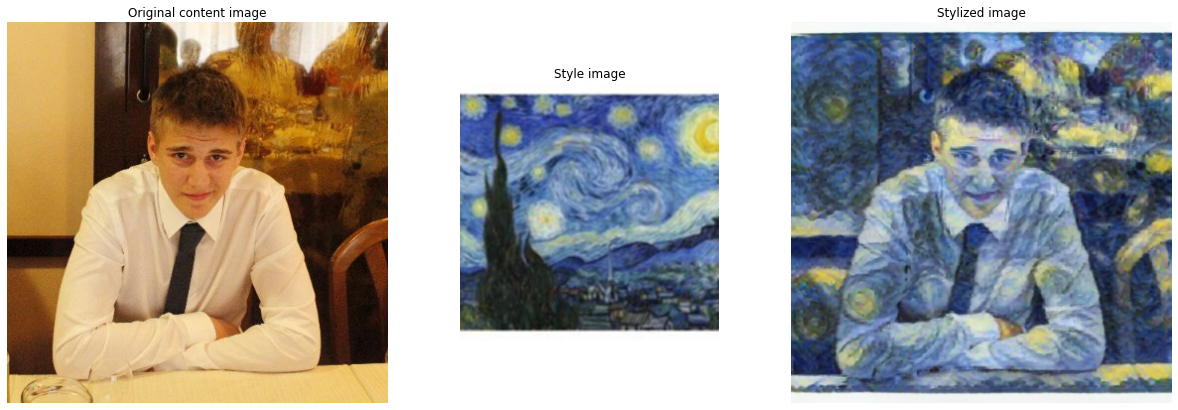

In [8]:
# Visualize input images and the generated stylized image.

show_n([content_image, style_image, stylized_image], titles=['Original content image', 'Style image', 'Stylized image'])

## Let's try it on more images

In [9]:
content_urls = dict(
  sea_turtle='https://upload.wikimedia.org/wikipedia/commons/d/d7/Green_Sea_Turtle_grazing_seagrass.jpg',
  tuebingen='https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg',
  grace_hopper='https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg',
  )
style_urls = dict(
  kanagawa_great_wave='https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg',
  kandinsky_composition_7='https://upload.wikimedia.org/wikipedia/commons/b/b4/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg',
  hubble_pillars_of_creation='https://upload.wikimedia.org/wikipedia/commons/6/68/Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg',
  van_gogh_starry_night='https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg',
  turner_nantes='https://upload.wikimedia.org/wikipedia/commons/b/b7/JMW_Turner_-_Nantes_from_the_Ile_Feydeau.jpg',
  munch_scream='https://upload.wikimedia.org/wikipedia/commons/c/c5/Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg',
  picasso_demoiselles_avignon='https://upload.wikimedia.org/wikipedia/en/4/4c/Les_Demoiselles_d%27Avignon.jpg',
  picasso_violin='https://upload.wikimedia.org/wikipedia/en/3/3c/Pablo_Picasso%2C_1911-12%2C_Violon_%28Violin%29%2C_oil_on_canvas%2C_Kr%C3%B6ller-M%C3%BCller_Museum%2C_Otterlo%2C_Netherlands.jpg',
  picasso_bottle_of_rum='https://upload.wikimedia.org/wikipedia/en/7/7f/Pablo_Picasso%2C_1911%2C_Still_Life_with_a_Bottle_of_Rum%2C_oil_on_canvas%2C_61.3_x_50.5_cm%2C_Metropolitan_Museum_of_Art%2C_New_York.jpg',
  fire='https://upload.wikimedia.org/wikipedia/commons/3/36/Large_bonfire.jpg',
  derkovits_woman_head='https://upload.wikimedia.org/wikipedia/commons/0/0d/Derkovits_Gyula_Woman_head_1922.jpg',
  amadeo_style_life='https://upload.wikimedia.org/wikipedia/commons/8/8e/Untitled_%28Still_life%29_%281913%29_-_Amadeo_Souza-Cardoso_%281887-1918%29_%2817385824283%29.jpg',
  derkovtis_talig='https://upload.wikimedia.org/wikipedia/commons/3/37/Derkovits_Gyula_Talig%C3%A1s_1920.jpg',
  amadeo_cardoso='https://upload.wikimedia.org/wikipedia/commons/7/7d/Amadeo_de_Souza-Cardoso%2C_1915_-_Landscape_with_black_figure.jpg'
)

content_image_size = 384
style_image_size = 256
content_images = {k: load_image(v, (content_image_size, content_image_size)) for k, v in content_urls.items()}
style_images = {k: load_image(v, (style_image_size, style_image_size)) for k, v in style_urls.items()}
style_images = {k: tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME') for k, style_image in style_images.items()}


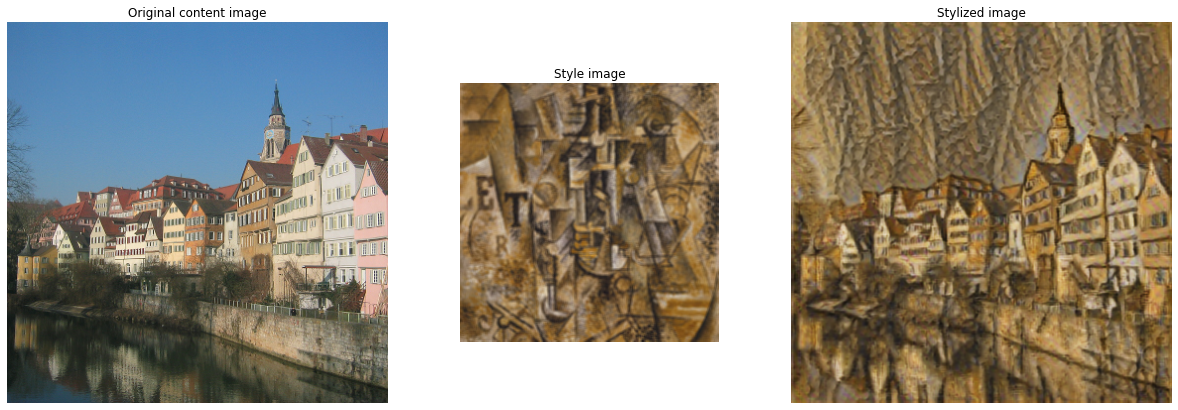

In [10]:
content_name = 'tuebingen'  # @param ['sea_turtle', 'tuebingen', 'grace_hopper']
style_name = 'picasso_bottle_of_rum'  # @param ['kanagawa_great_wave', 'kandinsky_composition_7', 'hubble_pillars_of_creation', 'van_gogh_starry_night', 'turner_nantes', 'munch_scream', 'picasso_demoiselles_avignon', 'picasso_violin', 'picasso_bottle_of_rum', 'fire', 'derkovits_woman_head', 'amadeo_style_life', 'derkovtis_talig', 'amadeo_cardoso']

stylized_image = hub_module(tf.constant(content_images[content_name]),
                            tf.constant(style_images[style_name]))[0]

show_n([content_images[content_name], style_images[style_name], stylized_image],
       titles=['Original content image', 'Style image', 'Stylized image'])

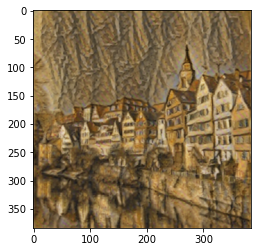

In [11]:
stylized_image = tf.reshape(stylized_image,(384,384,3))
plt.imshow(stylized_image)